### Notebook 4 of Capstone Project: Modelling Using Recurrent Neural Networks!

Summary of this notebook: 

Like the SARIMA modelling, I divided the Reccurrent Neural Network modelling up into 3 parts, one for each catalog. I did quite a bit of experimenting with model architecture and different features for each catalog, but here is just the high-level summary to give you an idea of which models showed promise for each catalog. For more detailed modelling, please see the equivalent notebook in the 'old_code' folder. I have many more RNN models in that notebook if you'd like to see more of my thought process. In summary though, I found the best models to have GRU layers and dropout in them, and the catalog/dataset that performed the best was the Mega dataset. I think because it had the biggest time range, there was more data to train on, and it actually performed pretty well using most of the activity level and completion parameter features. If you'd like to skip to those models, they can be found at the very end of this notebook. Enjoy!

Import the needed libraries here:

In [7]:
#the standard usual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#keras imports
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, GRU, Dense
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

#### Part 1: Modelling the TexNet/USGS catalog to start with.

In [8]:
data = pd.read_csv('oil_and_gas_data/data_for_modelling/data_ready_for_modelling.csv', index_col=0)
data.head()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-01,0.0,0.0,0,NaN,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502
2016-01-02,0.0,0.0,0,0.0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861
2016-01-03,0.0,0.0,0,0.0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135
2016-01-04,0.0,0.0,0,0.0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281
2016-01-05,0.0,0.0,0,0.0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281


In [9]:
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1859 entries, 2016-01-01 to 2021-02-01
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Avg          1859 non-null   float64
 1   Daily_Sum          1859 non-null   float64
 2   Daily_Count        1859 non-null   int64  
 3   Dly_Cnt_Diff       1858 non-null   float64
 4   Rig_Count          1760 non-null   float64
 5   WTI_Spot_Price     1859 non-null   float64
 6   Brent_Spot_Price   1859 non-null   float64
 7   fracs_per_day      1801 non-null   float64
 8   volume_per_day     1801 non-null   float64
 9   avg_volh2o_per_ft  1695 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 159.8 KB


In [10]:
#drop the Nan's from the data
data_model = data.dropna()
data_model.head()

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2016-01-02,0.0,0.0,0,0.0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861
2016-01-03,0.0,0.0,0,0.0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135
2016-01-04,0.0,0.0,0,0.0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281
2016-01-05,0.0,0.0,0,0.0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281
2016-01-06,0.0,0.0,0,0.0,33.0,33.97,33.89,26.0,1.195583e+07,813.047953


I will set up a regression model here, trying Daily_Count_Difference as the target and using fracs_per_day as my first feature to test.

In [11]:
#I'll redefine X and y here
#x is the same
X = data_model[['fracs_per_day']]
#y will just be the Dly_Cnt_Diff column
y = data_model['Dly_Cnt_Diff']

In [12]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [13]:
#now need to scale the data
sscaler = StandardScaler()

In [14]:
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [15]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [16]:
batch_x, batch_y = train_sequences[0]

In [17]:
batch_x.shape

(64, 7, 1)

In [18]:
#I'm going to use a simple RNN to start
model2 = Sequential()
model2.add(SimpleRNN(8, input_shape = (7,1)))
model2.add(Dense(20, activation = 'relu'))
model2.add(Dense(1))

In [19]:
model2.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])

In [20]:
history2 = model2.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

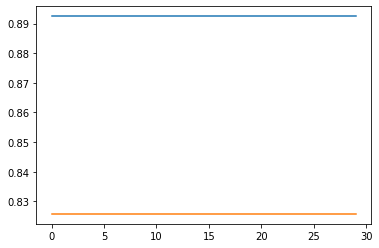

In [21]:
#let's look at our accuracy
plt.plot(history2.history['acc'], label='accuracy')
plt.plot(history2.history['val_acc'], label = 'val_accuracy')

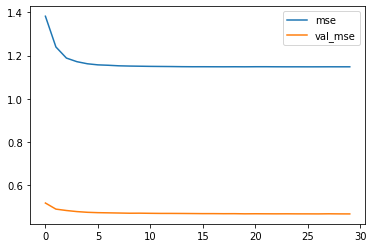

In [22]:
#let's look at our loss/mse
plt.plot(history2.history['mse'], label='mse')
plt.plot(history2.history['val_mse'], label='val_mse')
plt.legend();

This is doing about as good as our simple mean rmse that we ran prior to doing the ARIMA model. Recall that our rmse using the simple mean was 0.4. 

For this catalog, I tested single and multiple GRU layers, dropout, Bidirectional, LSTM, using all of the features together, etc and never really did better than the null model. And they all used the same target, Daily_Count_Diff. So, my next step with that catalog was to cut the time range down a little more, and then change to the Daily_Sum target. That's what I did next here.

In [23]:
data_small = data_model.loc['10-1-2017':'3-31-2020',]

In [24]:
data_small

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2017-10-01,0.0,0.0,0,0.0,27.0,51.67,57.02,47.0,2.651121e+07,2057.055001
2017-10-02,0.0,0.0,0,0.0,27.0,50.59,55.67,46.0,2.490001e+07,2055.337718
2017-10-03,0.0,0.0,0,0.0,27.0,50.44,56.12,46.0,2.490001e+07,2055.337718
2017-10-04,0.0,0.0,0,0.0,27.0,50.00,56.00,23.0,1.212874e+07,1868.106876
2017-10-05,0.0,0.0,0,0.0,27.0,50.79,57.09,19.0,1.072558e+07,1911.134559
...,...,...,...,...,...,...,...,...,...,...
2020-03-27,0.0,0.0,0,-1.0,33.0,15.48,22.39,33.0,1.874334e+07,2329.799570
2020-03-28,0.0,0.0,0,0.0,30.0,15.48,22.39,33.0,1.874334e+07,2329.799570
2020-03-29,0.0,0.0,0,0.0,30.0,15.48,22.39,33.0,1.874334e+07,2329.799570
2020-03-30,0.0,0.0,0,0.0,30.0,14.10,19.19,33.0,1.874334e+07,2329.799570


In [25]:
X = data_small[['Rig_Count', 'WTI_Spot_Price', 'volume_per_day', 'avg_volh2o_per_ft']]
#y will be the daily_sum column
y = data_small['Daily_Sum']

In [26]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [27]:
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [28]:
#break up the data into 3-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)

In [29]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 3, 4)

In [30]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [31]:
#I'm going to use multiple GRUs
model11 = Sequential()
model11.add(GRU(10, input_shape = (3,4), return_sequences=True))
model11.add(GRU(50, return_sequences=True))
model11.add(GRU(100))
model11.add(Dense(20, activation = 'relu'))
model11.add(Dense(1))

model11.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history11 = model11.fit(train_sequences, validation_data=test_sequences, epochs=30, verbose=0)

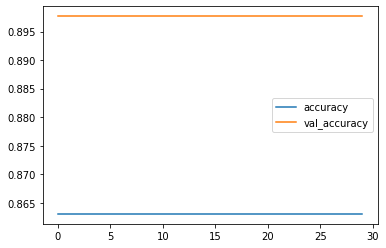

In [32]:
#let's look at our accuracy
plt.plot(history11.history['acc'], label='accuracy')
plt.plot(history11.history['val_acc'], label = 'val_accuracy')
plt.legend();

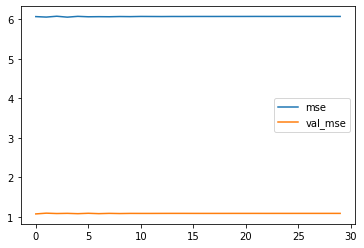

In [33]:
#let's look at our loss/mse
plt.plot(history11.history['mse'], label='mse')
plt.plot(history11.history['val_mse'], label='val_mse')
plt.legend();

The result overall is that using the Daily_Sum target gave a little bit better results. Still around the null, but better than the first target. Using this same catalog, I then resampled the data to weekly, and then remodelled. It did a little bit better than the null, see here below.

In [34]:
weekly_data_small = data_small.resample('W').mean()
weekly_data_small

,Daily_Avg,Daily_Sum,Daily_Count,Dly_Cnt_Diff,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2017-10-01,0.000000,0.000000,0.000000,0.0,27.000000,51.670000,57.020000,47.000000,2.651121e+07,2057.055001
2017-10-08,0.000000,0.000000,0.000000,0.0,27.571429,49.977143,55.911429,27.142857,1.480486e+07,1940.390559
2017-10-15,0.000000,0.000000,0.000000,0.0,29.857143,50.958571,56.392857,16.142857,9.249819e+06,1928.475138
2017-10-22,0.000000,0.000000,0.000000,0.0,32.285714,51.708571,57.808571,14.714286,7.058174e+06,2132.500242
2017-10-29,0.000000,0.000000,0.000000,0.0,33.857143,52.910000,59.025714,13.142857,6.712036e+06,2241.499288
...,...,...,...,...,...,...,...,...,...,...
2020-03-08,0.000000,0.000000,0.000000,0.0,32.714286,44.307143,49.244286,28.000000,2.196417e+07,2541.374936
2020-03-15,0.000000,0.000000,0.000000,0.0,32.000000,32.195714,33.302857,30.571429,2.360722e+07,2545.060663
2020-03-22,0.000000,0.000000,0.000000,0.0,32.285714,22.847143,25.624286,32.000000,2.262417e+07,2586.057358
2020-03-29,0.271429,0.271429,0.142857,0.0,32.142857,18.307143,23.512857,33.000000,1.900354e+07,2374.692438


In [35]:
X = weekly_data_small[['Rig_Count', 'WTI_Spot_Price', 'volume_per_day', 'avg_volh2o_per_ft']]
#y will be the daily_sum column
y = weekly_data_small['Daily_Sum']

In [36]:
#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [37]:
#make a baseline model to compare against
mean_y_train_array = np.full_like(y_train, y_train.mean())
mean_squared_error(y_train, mean_y_train_array, squared=False)

1.1714938470277203

In [38]:
mean_y_test_array = np.full_like(y_test, y_test.mean())
mean_squared_error(y_test, mean_y_test_array, squared=False)

0.38621267862288555

In [39]:
#now set up the RNN
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [40]:
#break up the data into 3-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 3, 4)

In [41]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=3, batch_size=64)

In [42]:
#I'm going to use multiple GRUs
model13 = Sequential()
model13.add(GRU(10, input_shape = (3,4), return_sequences=True))
model13.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model13.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model13.add(Dense(20, activation = 'relu'))
model13.add(Dense(1))

model13.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
history13 = model13.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

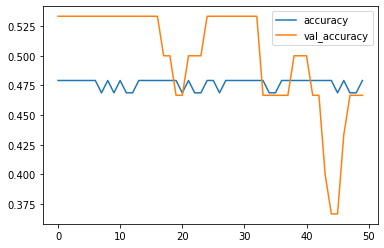

In [43]:
#let's look at our accuracy
plt.plot(history13.history['acc'], label='accuracy')
plt.plot(history13.history['val_acc'], label = 'val_accuracy')
plt.legend();

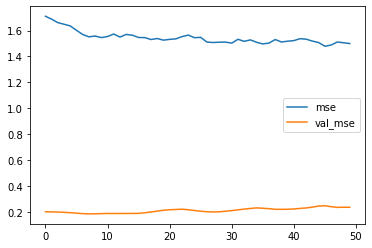

In [44]:
#let's look at our loss/mse
plt.plot(history13.history['mse'], label='mse')
plt.plot(history13.history['val_mse'], label='val_mse')
plt.legend();

This was likely my best model with the TexNet/USGS dataset. With more time, I would have liked to do some modelling using the Daily_Average target. That will have to go under future work.

#### Part 2: Modelling the Fasola catalog/dataset

In [45]:
fasola = pd.read_csv('oil_and_gas_data/data_for_modelling/fasola_data_ready_for_modelling.csv', index_col=0)
fasola.head()

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2016-01-01,0.0,0.0,0,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-02,0.0,0.0,0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-03,0.0,0.0,0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-04,0.0,0.0,0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-05,0.0,0.0,0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."


In [46]:
fasola.index = pd.to_datetime(fasola.index)
fasola.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1859 entries, 2016-01-01 to 2021-02-01
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Avg          1859 non-null   float64
 1   Daily_Sum          1859 non-null   float64
 2   Daily_Count        1859 non-null   int64  
 3   Rig_Count          1760 non-null   float64
 4   WTI_Spot_Price     1859 non-null   float64
 5   Brent_Spot_Price   1859 non-null   float64
 6   fracs_per_day      1801 non-null   float64
 7   volume_per_day     1801 non-null   float64
 8   avg_volh2o_per_ft  1695 non-null   float64
 9   APIs               1801 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 159.8+ KB


In [47]:
#drop the Nan's from the data
fasola_model = fasola.dropna()
fasola_model.head()

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2016-01-01,0.0,0.0,0,33.0,37.13,36.61,9.0,5.080098e+06,1088.829502,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-02,0.0,0.0,0,33.0,37.13,36.61,11.0,5.892634e+06,1044.749861,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-03,0.0,0.0,0,33.0,37.13,36.61,9.0,4.539134e+06,1125.551135,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-04,0.0,0.0,0,33.0,36.81,36.28,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."
2016-01-05,0.0,0.0,0,33.0,35.97,35.56,26.0,1.135010e+07,848.112281,"[42255346090000, 42255346080000, 4225534610000..."


In [48]:
#I'm going to model a large time range since these models tend to run fast
#the Jan 31, 2020 cutoff is the last meaningful data before COVID started to impact activity
fasola_model = fasola_model.loc['1-1-2017':'1-31-2020']
fasola_model

,Daily_Avg,Daily_Sum,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2017-01-01,0.000000,0.000000,0,24.0,53.75,54.96,9.0,7.562982e+06,1793.684306,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-02,0.766226,2.298677,3,24.0,53.75,54.96,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-03,0.792245,34.066545,43,24.0,52.36,55.05,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-04,1.025187,10.251870,10,24.0,53.26,54.57,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
2017-01-05,1.600100,1.600100,1,24.0,53.77,54.99,9.0,7.942106e+06,1721.140972,"[42255343990000, 42255344150000, 4225535062000..."
...,...,...,...,...,...,...,...,...,...,...
2020-01-27,0.000000,0.000000,0,33.0,53.09,58.54,45.0,4.278683e+07,1642.821249,"[42255361860000, 42255361850000, 4225536569000..."
2020-01-28,1.900000,1.900000,1,33.0,53.33,59.37,46.0,4.433917e+07,1658.283946,"[42255361860000, 42255361850000, 4225536569000..."
2020-01-29,0.000000,0.000000,0,33.0,53.29,59.46,44.0,4.293038e+07,1624.508496,"[42255361860000, 42255361850000, 4225536569000..."
2020-01-30,0.000000,0.000000,0,33.0,52.19,57.72,46.0,4.500210e+07,1624.812672,"[42255361860000, 42255361850000, 4225536556000..."


In [49]:
X = fasola_model[['fracs_per_day','volume_per_day','avg_volh2o_per_ft']]
#y will be the daily_sum column
y = fasola_model['Daily_Sum']

In [50]:
#split into train and test data; remember default is 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [51]:
#set up our null model
mean_y_train_array = np.full_like(y_train, y_train.mean())
mean_squared_error(y_train, mean_y_train_array, squared=False)

6.721847536786381

In [52]:
mean_y_test_array = np.full_like(y_test, y_test.mean())
mean_squared_error(y_test, mean_y_test_array, squared=False)

1.3249649424665666

In [53]:
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [54]:
#break up the data into 7-day stacks
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)

In [55]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 3)

In [56]:
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [57]:
#I'm going to use dropout with the multiple GRUs
modelf2 = Sequential()
modelf2.add(GRU(10, input_shape = (7,3), return_sequences=True))
modelf2.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelf2.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelf2.add(Dense(20, activation = 'relu'))
modelf2.add(Dense(1))

modelf2.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historyf2 = modelf2.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

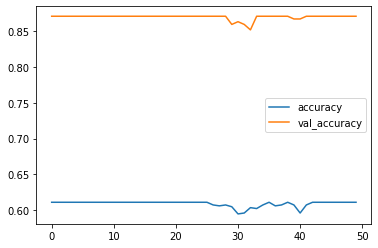

In [58]:
#let's look at our accuracy
plt.plot(historyf2.history['acc'], label='accuracy')
plt.plot(historyf2.history['val_acc'], label = 'val_accuracy')
plt.legend();

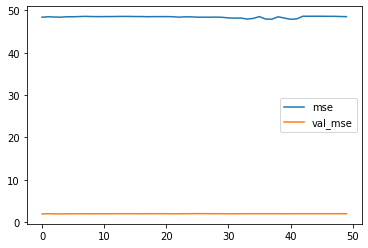

In [59]:
#let's look at our loss/mse
plt.plot(historyf2.history['mse'], label='mse')
plt.plot(historyf2.history['val_mse'], label='val_mse')
plt.legend();

For the Fasola dataset, I only ran two models, one without dropout and one with. Neither really did better than the null model. Again, with more time, I'd like to experiment more with the Daily_Average target, but I didn't discover it was the best target to use until later on my project. So, I'll have to add this to the future work list.

#### Part 3: Modelling the Mega Catalog/Dataset

Modelling the Mega Dataset using Daily Average as the target. I also resmapled this dataset to the Weekly Average because it is composed of all three catalogs and goes back to 2012 (that's why it's called Mega!).

In [60]:
mega_df = pd.read_csv('oil_and_gas_data/data_for_modelling/mega_data_ready_for_modelling.csv', index_col=0)

In [61]:
#first thing to do is drop na values
mega_df = mega_df.dropna()
mega_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2863 entries, 2012-03-02 to 2020-12-05
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Daily_Sum          2863 non-null   float64
 1   Daily_Avg          2863 non-null   float64
 2   Daily_Count        2863 non-null   int64  
 3   Rig_Count          2863 non-null   float64
 4   WTI_Spot_Price     2863 non-null   float64
 5   Brent_Spot_Price   2863 non-null   float64
 6   fracs_per_day      2863 non-null   float64
 7   volume_per_day     2863 non-null   float64
 8   avg_volh2o_per_ft  2863 non-null   float64
 9   APIs               2863 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 246.0+ KB


In [62]:
mega_df.index = pd.to_datetime(mega_df.index)
mega_df = mega_df.loc[:'1-31-2020',]
mega_df.tail()

,Daily_Sum,Daily_Avg,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft,APIs
2020-01-27,0.0,0.0,0,33.0,53.09,58.54,45.0,4.278683e+07,1642.821249,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-28,1.9,1.9,1,33.0,53.33,59.37,46.0,4.433917e+07,1658.283946,"[42255361850000, 42255361860000, 4225536568000..."
2020-01-29,0.0,0.0,0,33.0,53.29,59.46,44.0,4.293038e+07,1624.508496,"[42255361850000, 42255361860000, 4225536569000..."
2020-01-30,0.0,0.0,0,33.0,52.19,57.72,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."
2020-01-31,0.0,0.0,0,33.0,51.58,57.77,46.0,4.500210e+07,1624.812672,"[42255361850000, 42255361860000, 4225536559000..."


In [63]:
#time to resample to Weekly averages
mega_df_weekly = mega_df.resample('W').mean()
mega_df_weekly.dropna(inplace=True)
mega_df_weekly.head()

,Daily_Sum,Daily_Avg,Daily_Count,Rig_Count,WTI_Spot_Price,Brent_Spot_Price,fracs_per_day,volume_per_day,avg_volh2o_per_ft
2012-03-04,0.0,0.0,0.0,101.000000,106.680000,125.930000,8.0,6.358212e+06,602.103409
2012-03-11,0.0,0.0,0.0,101.000000,105.705000,125.855000,8.0,6.358212e+06,602.103409
2012-03-25,0.0,0.0,0.0,101.000000,106.430000,125.210000,1.0,9.870840e+05,373.895455
2012-04-01,0.0,0.0,0.0,101.000000,107.070000,125.850000,1.0,9.870840e+05,373.895455
2012-06-03,0.0,0.0,0.0,98.666667,85.761667,101.858333,1.0,8.432639e+05,1117.963447


In [64]:
#define my X and y 
X = mega_df_weekly[['avg_volh2o_per_ft']]
y = mega_df_weekly['Daily_Avg']

In [65]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [66]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [67]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [68]:
X_train_sc.shape

(289, 1)

In [69]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 1)

In [70]:
#I'm going to use multiple GRUs
modelm1 = Sequential()
modelm1.add(GRU(10, input_shape = (7,1), return_sequences=True))
modelm1.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm1.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm1.add(Dense(20, activation = 'relu'))
modelm1.add(Dense(1))

modelm1.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym1 = modelm1.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

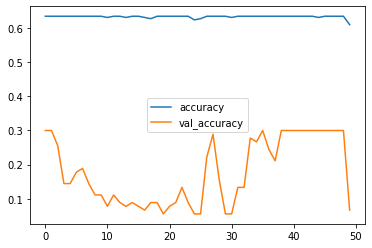

In [71]:
#let's look at our accuracy
plt.plot(historym1.history['acc'], label='accuracy')
plt.plot(historym1.history['val_acc'], label = 'val_accuracy')
plt.legend();

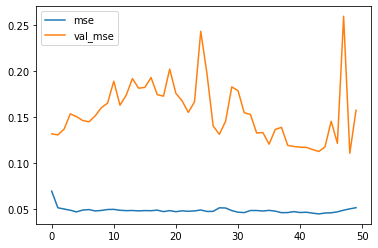

In [72]:
#let's look at our mse
plt.plot(historym1.history['mse'], label='mse')
plt.plot(historym1.history['val_mse'], label='val_mse')
plt.legend();

In [73]:
#I need to set up a null/baseline model to compare to
mean_y_train_array = np.full_like(y_train, y_train.mean())
mean_squared_error(y_train, mean_y_train_array, squared=False)

0.24662795519027217

In [74]:
mean_y_test_array = np.full_like(y_test, y_test.mean())
mean_squared_error(y_test, mean_y_test_array, squared=False)

0.3379607320070323

I think I have a model that beat the nulls! The accuracy isn't great, but the rmse values look really good! 

Now I'd like to add in the fracs_per_day data with the other features and see how that does.

In [75]:
#define my X and y 
X = mega_df_weekly[['fracs_per_day','volume_per_day','avg_volh2o_per_ft']]
y = mega_df_weekly['Daily_Avg']

In [76]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [77]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [78]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [79]:
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 7, 3)

In [80]:
#I'm going to use multiple GRUs like before, but I want to try more epochs
modelm4 = Sequential()
modelm4.add(GRU(10, input_shape = (7,3), return_sequences=True))
modelm4.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm4.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm4.add(Dense(20, activation = 'relu'))
modelm4.add(Dense(1))

modelm4.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym4 = modelm4.fit(train_sequences, validation_data=test_sequences, epochs=60, verbose=0)

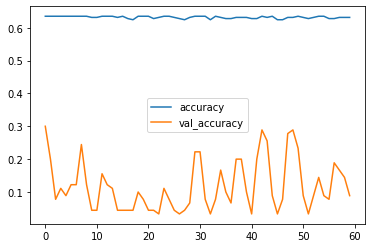

In [81]:
#let's look at our accuracy
plt.plot(historym4.history['acc'], label='accuracy')
plt.plot(historym4.history['val_acc'], label = 'val_accuracy')
plt.legend();

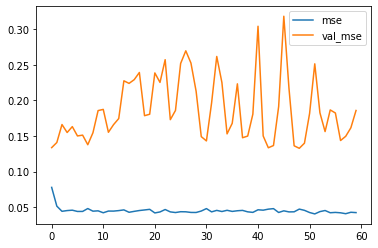

In [82]:
#let's look at our mse
plt.plot(historym4.history['mse'], label='mse')
plt.plot(historym4.history['val_mse'], label='val_mse')
plt.legend();

I think this model actually got down to a lower val rmse (down to ~0.15), which is the best yet. The extra epochs didn't really help though.

Since we seem to be improving with each feature, I added the last two in there, which are the WTI and Brent Spot Prices. It did not do as well, so I took the Brent Price out and moved forward to acheive my best model.

In [163]:
#define my X and y 
X = mega_df_weekly[['fracs_per_day','volume_per_day','avg_volh2o_per_ft', 'Rig_Count', 'WTI_Spot_Price']]
y = mega_df_weekly['Daily_Avg']

In [164]:
#splitting into train and test sets; remember to use shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [193]:
y_test

2018-04-01    0.000000
2018-04-08    0.000000
2018-04-15    0.223663
2018-04-22    0.528247
2018-04-29    0.620691
                ...   
2020-01-05    0.571429
2020-01-12    0.635714
2020-01-19    0.607143
2020-01-26    0.928571
2020-02-02    0.380000
Name: Daily_Avg, Length: 97, dtype: float64

In [166]:
#now need to scale the data
sscaler = StandardScaler()
X_train_sc = sscaler.fit_transform(X_train)
X_test_sc = sscaler.transform(X_test)

In [167]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=7, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=7, batch_size=64)

In [174]:
batch_x0, batch_y0 = train_sequences[0]
batch_x0.shape

(64, 7, 5)

In [88]:
#I'm going to use multiple GRUs like before, but I want to try more epochs
modelm7 = Sequential()
modelm7.add(GRU(10, input_shape = (7,5), return_sequences=True))
modelm7.add(GRU(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
modelm7.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
modelm7.add(Dense(20, activation = 'relu'))
modelm7.add(Dense(1))

modelm7.compile(loss='mae', optimizer = 'adam', metrics=['acc', 'mse'])
historym7 = modelm7.fit(train_sequences, validation_data=test_sequences, epochs=50, verbose=0)

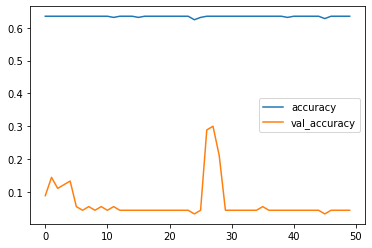

In [89]:
#let's look at our accuracy
plt.plot(historym7.history['acc'], label='accuracy')
plt.plot(historym7.history['val_acc'], label = 'val_accuracy')
plt.legend();

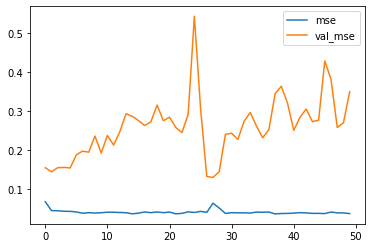

In [90]:
#let's look at our mse
plt.plot(historym7.history['mse'], label='mse')
plt.plot(historym7.history['val_mse'], label='val_mse')
plt.legend();

This was my best model because it had the lowest rmse scores for train and test sets. I then went on to try out a Convo1D and MaxPooling layer, but it did not do as well. 

I think can conclude that my best models so far are these last few. The rmse's are the lowest I've seen with the RNN. I think this is a combination of using all of my data (a much bigger time range than before) and using the best target: Daily Average Magnitude. From this last bit of modelling, I've also found that the most important features to use for predicting are Total Volume injected/day, Avg Volume of water injected/ft of lateral, the # of fracs going on per day, and the WTI Spot Price (a key indicator of activity level). 